In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
plt.style.use("seaborn-v0_8-darkgrid")

In [101]:
# Load OGLE Cepheid catalog (LMC)
data_path = Path("asu.tsv")
df = pd.read_csv(data_path, sep="\t", comment="#")

# Convert selected columns to numeric
num_cols = ["Per", "Vmag", "Imag", "E(B-V)"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep rows with *all* three mags present
clean = df[["Per", "Vmag", "Imag"]].dropna(subset=["Per", "Vmag", "Imag"])

In [102]:
display(clean.describe())

,Per,Vmag,Imag
count,204.000000,204.000000,204.000000
mean,4.478774,15.850598,15.128294
std,4.841457,0.827237,0.749328
min,0.403540,9.999000,13.056000
25%,2.354130,15.512750,14.761000
50%,3.375205,15.856000,15.122500
75%,4.896888,16.214750,15.416000
max,56.498190,18.870000,17.751000


Number of Classical Cepheids: 195
Number of Other Cepheids: 9


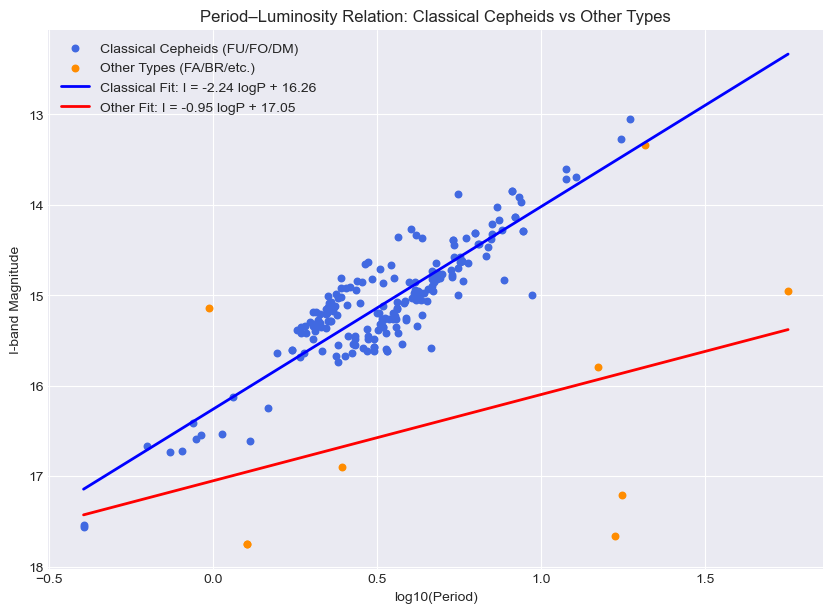

In [110]:
# -------------------------------
# Separate Classical vs Other Cepheids
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Classical Cepheid codes
classical_labels = ["FU", "FO", "DM"]   # fundamental, first overtone, double-mode = Type I

# Subsets
df_classical = clean_all[clean_all["Type"].isin(classical_labels)].copy()
df_other     = clean_all[~clean_all["Type"].isin(classical_labels)].copy()

print("Number of Classical Cepheids:", len(df_classical))
print("Number of Other Cepheids:", len(df_other))

# Compute log10 Period (column name is 'Per')
df_classical["logP"] = np.log10(df_classical["Per"])
df_other["logP"]     = np.log10(df_other["Per"])

# Define linear P–L model
def linear(x, a, b):
    return a * x + b

# Fit classical
popt_classical, _ = curve_fit(linear, df_classical["logP"], df_classical["Imag"])
a_c, b_c = popt_classical

# Fit other
popt_other, _ = curve_fit(linear, df_other["logP"], df_other["Imag"])
a_o, b_o = popt_other

# -------------------------------
# Plot Classical vs Other with Fits
# -------------------------------
plt.figure(figsize=(10, 7))

# Scatter points
plt.scatter(df_classical["logP"], df_classical["Imag"],
            color="royalblue", s=22, label="Classical Cepheids (FU/FO/DM)")

plt.scatter(df_other["logP"], df_other["Imag"],
            color="darkorange", s=22, label="Other Types (FA/BR/etc.)")

# Fit lines
xfit = np.linspace(min(clean_all["Per"].apply(np.log10)),
                   max(clean_all["Per"].apply(np.log10)), 200)

plt.plot(xfit, linear(xfit, a_c, b_c), color="blue", linewidth=2,
         label=f"Classical Fit: I = {a_c:.2f} logP + {b_c:.2f}")

plt.plot(xfit, linear(xfit, a_o, b_o), color="red", linewidth=2,
         label=f"Other Fit: I = {a_o:.2f} logP + {b_o:.2f}")

plt.gca().invert_yaxis()  # brighter = up
plt.xlabel("log10(Period)")
plt.ylabel("I-band Magnitude")
plt.title("Period–Luminosity Relation: Classical Cepheids vs Other Types")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# Period–Luminosity model: V = a * log10(P) + b
def pl_model(logP, a, b):
    return a * logP + b

logP = np.log10(clean["Per"].values)
V    = clean["Vmag"].values

popt, pcov = curve_fit(pl_model, logP, V)
a, b = popt
a_err, b_err = np.sqrt(np.diag(pcov))
print(f"a = {a:.3f} ± {a_err:.3f}")
print(f"b = {b:.3f} ± {b_err:.3f}")

a = -1.816 ± 0.154
b = 16.834 ± 0.095


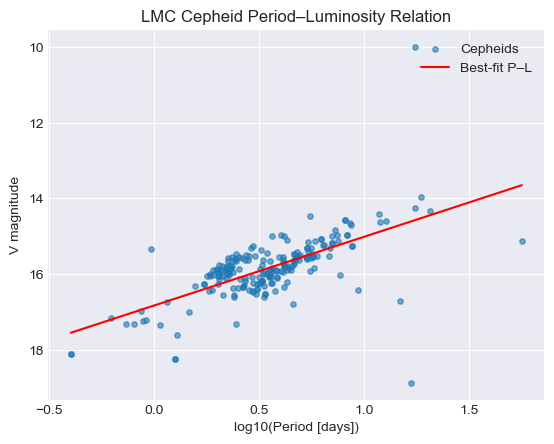

In [105]:
plt.figure()
plt.scatter(logP, V, s=15, alpha=0.6, label="Cepheids")

x = np.linspace(logP.min(), logP.max(), 200)
plt.plot(x, pl_model(x, a, b), color="red", label="Best-fit P–L")

plt.gca().invert_yaxis()
plt.xlabel("log10(Period [days])")
plt.ylabel("V magnitude")
plt.legend()
plt.title("LMC Cepheid Period–Luminosity Relation")
plt.show()

Estimated RMS scatter of residuals: 0.638 mag
Reduced chi^2 = 1.00


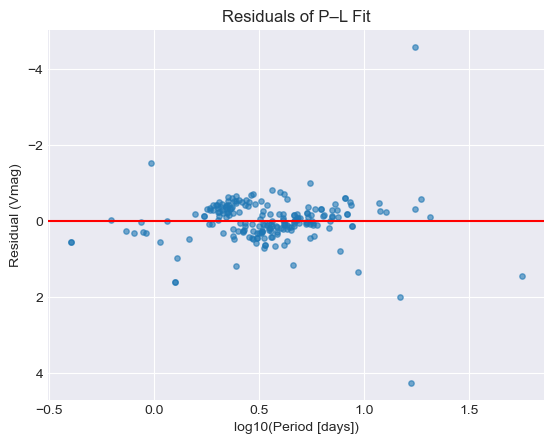

In [106]:
# --- Reduced chi^2 using the actual scatter of the data ---

# 0. Recompute logP, V and residuals from the *current* clean
logP = np.log10(clean["Per"].values)
V    = clean["Vmag"].values
resid = V - pl_model(logP, a, b)

# 1. Estimate typical uncertainty from the scatter of residuals
sigma_est = np.std(resid, ddof=2)     # ddof = #params = 2
print(f"Estimated RMS scatter of residuals: {sigma_est:.3f} mag")

# 2. Compute chi^2 and reduced chi^2
chi2 = np.sum((resid / sigma_est)**2)
dof  = len(resid) - 2
chi2_red = chi2 / dof
print(f"Reduced chi^2 = {chi2_red:.2f}")

# 3. Residual plot
plt.figure()
plt.scatter(logP, resid, s=15, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("log10(Period [days])")
plt.ylabel("Residual (Vmag)")
plt.title("Residuals of P–L Fit")
plt.gca().invert_yaxis()
plt.show()

Number of Type II *candidates* (P–L outliers): 4


,Per,Vmag,Imag
8,16.74144,18.870,17.666
9,14.87020,16.716,15.790
61,1.26602,18.249,17.751
64,1.26602,18.249,17.751


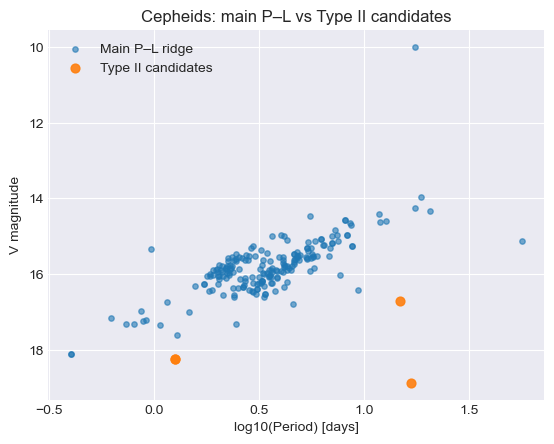

In [107]:
# --- Identify Type II candidates using only period + luminosity ---

# 1. Log period and observed V (already used above)
logP = np.log10(clean["Per"].values)
V    = clean["Vmag"].values

# 2. Residuals from the current P–L fit
V_model = pl_model(logP, a, b)
resid   = V - V_model   # +ve = fainter than the classical P–L ridge

# 3. Define a simple threshold for "much fainter" stars
threshold = 1.5   # mag; explain this choice in your write-up
cand_mask = resid > threshold

candidates = clean[cand_mask].copy()
print(f"Number of Type II *candidates* (P–L outliers): {len(candidates)}")
display(candidates.head())

# 4. Plot: classical ridge vs Type II candidates
plt.figure()
plt.scatter(logP[~cand_mask], V[~cand_mask], s=15, alpha=0.6, label="Main P–L ridge")
plt.scatter(logP[cand_mask], V[cand_mask], s=40, alpha=0.9, label="Type II candidates")
plt.gca().invert_yaxis()
plt.xlabel("log10(Period) [days]")
plt.ylabel("V magnitude")
plt.title("Cepheids: main P–L vs Type II candidates")
plt.legend()
plt.show()

Absolute P–L slope:      a_abs = -1.816 ± 0.154
Absolute P–L intercept: b_abs = -1.666 ± 0.095


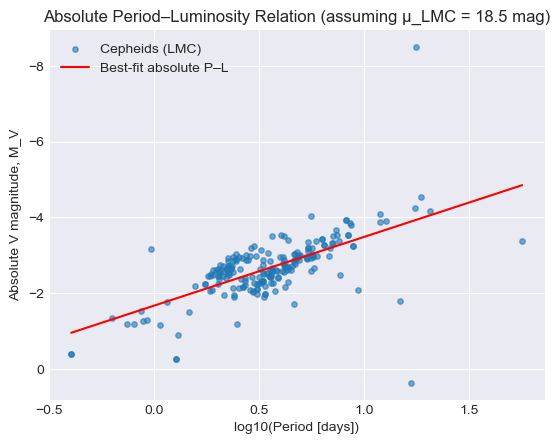

In [108]:
# --- Extra: convert to absolute magnitudes and refit P–L relation ---

# 1. Adopt a distance modulus for the LMC (literature value)
mu_LMC = 18.5   # mag, you can mention this assumption in your write-up

# 2. Compute absolute V magnitude for each Cepheid
M_V = clean["Vmag"].values - mu_LMC

# 3. Refit P–L relation using absolute magnitudes
logP = np.log10(clean["Per"].values)

def pl_model_abs(logP, a_abs, b_abs):
    return a_abs * logP + b_abs

popt_abs, pcov_abs = curve_fit(pl_model_abs, logP, M_V)
a_abs, b_abs = popt_abs
a_abs_err, b_abs_err = np.sqrt(np.diag(pcov_abs))

print(f"Absolute P–L slope:      a_abs = {a_abs:.3f} ± {a_abs_err:.3f}")
print(f"Absolute P–L intercept: b_abs = {b_abs:.3f} ± {b_abs_err:.3f}")

# 4. Plot absolute-magnitude P–L relation
plt.figure()
plt.scatter(logP, M_V, s=15, alpha=0.6, label="Cepheids (LMC)")
x = np.linspace(logP.min(), logP.max(), 200)
plt.plot(x, pl_model_abs(x, a_abs, b_abs), color="red", label="Best-fit absolute P–L")

plt.gca().invert_yaxis()
plt.xlabel("log10(Period [days])")
plt.ylabel("Absolute V magnitude, M_V")
plt.title("Absolute Period–Luminosity Relation (assuming μ_LMC = 18.5 mag)")
plt.legend()
plt.show()

Counts:
FU (Fundamental): 118
FO (First Overtone): 69
DM (Double Mode): 8
Other Types: 9


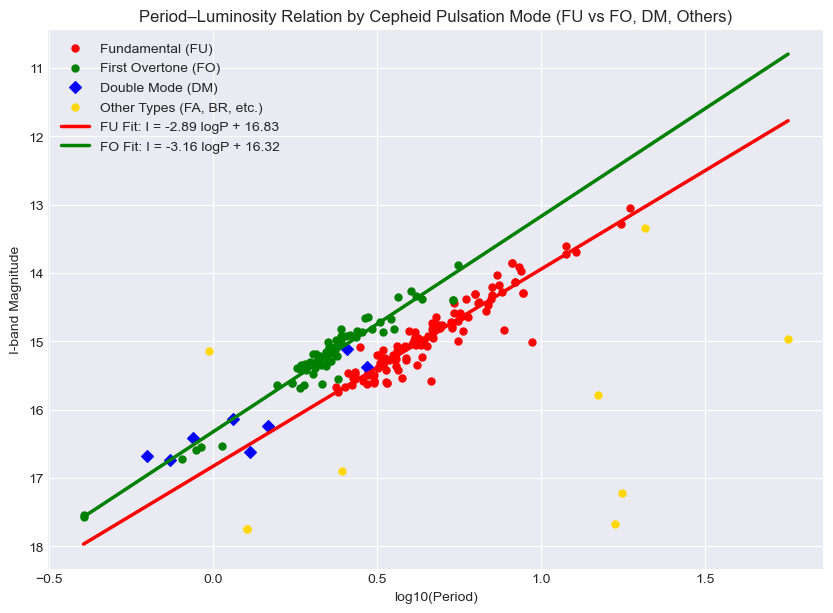

In [111]:
# ---------------------------------------------------------
# Separate FU vs FO vs DM vs Others and plot all together
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract relevant columns from your cleaned table:
df = clean_all.copy()

# Make period column
df["logP"] = np.log10(df["Per"])

# --------------------------
# 1. Define categories
# --------------------------
fundamental = df[df["Type"] == "FU"]          # Fundamental mode
first_overtone = df[df["Type"] == "FO"]       # First-overtone mode
double_mode = df[df["Type"] == "DM"]          # Double-mode
other_types = df[~df["Type"].isin(["FU", "FO", "DM"])]   # Everything else (FA, BR, etc.)

print("Counts:")
print("FU (Fundamental):", len(fundamental))
print("FO (First Overtone):", len(first_overtone))
print("DM (Double Mode):", len(double_mode))
print("Other Types:", len(other_types))

# --------------------------
# 2. Linear model for P–L
# --------------------------
def PL_model(x, a, b):
    return a * x + b

# Fit FU
popt_FU, _ = curve_fit(PL_model, fundamental["logP"], fundamental["Imag"])
a_FU, b_FU = popt_FU

# Fit FO
popt_FO, _ = curve_fit(PL_model, first_overtone["logP"], first_overtone["Imag"])
a_FO, b_FO = popt_FO

# Line fit range
xfit = np.linspace(df["logP"].min(), df["logP"].max(), 300)

# --------------------------
# 3. Plot everything
# --------------------------
plt.figure(figsize=(10, 7))

# Scatter all categories in unique colors:
plt.scatter(fundamental["logP"], fundamental["Imag"],
            s=25, color="red", label="Fundamental (FU)")

plt.scatter(first_overtone["logP"], first_overtone["Imag"],
            s=25, color="green", label="First Overtone (FO)")

plt.scatter(double_mode["logP"], double_mode["Imag"],
            s=35, color="blue", marker="D", label="Double Mode (DM)")

plt.scatter(other_types["logP"], other_types["Imag"],
            s=25, color="gold", label="Other Types (FA, BR, etc.)")

# Plot fit lines for FU & FO
plt.plot(xfit, PL_model(xfit, a_FU, b_FU),
         color="red", linewidth=2.5, label=f"FU Fit: I = {a_FU:.2f} logP + {b_FU:.2f}")

plt.plot(xfit, PL_model(xfit, a_FO, b_FO),
         color="green", linewidth=2.5, label=f"FO Fit: I = {a_FO:.2f} logP + {b_FO:.2f}")

plt.gca().invert_yaxis()  # Brighter magnitude = lower number
plt.xlabel("log10(Period)")
plt.ylabel("I-band Magnitude")
plt.title("Period–Luminosity Relation by Cepheid Pulsation Mode (FU vs FO, DM, Others)")
plt.grid(True)
plt.legend()
plt.show()